####################

July 1st, 2025

- Joining the trans and cis into a single file
- Generating a filtered pairs file for each replicate, transforming them to coolers and then merging the coolers
- Balancing the merged coolers


Loading in some libraries

In [22]:
import sys
import gzip
import matplotlib.pyplot as plt
import numpy as np
import cooler
import pandas as pd
import cooltools

Ploting the unbalanced merged diploid cooler

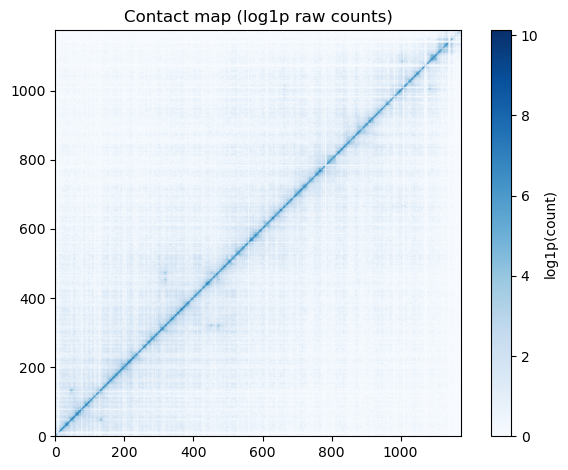

In [31]:
clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250403_PnMs_merged_diploidGenome.20kb.cool")

# Example: plot chromosome 2L (you can adjust)
mat = clr.matrix(balance=False).fetch("2L_JJg14_057")

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("Contact map (log1p raw counts)")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()

Balancing the cooler

In [32]:
cool_path = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250403_PnMs_merged_diploidGenome.20kb.cool"
balanced_cool_path = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250403_PnMs_merged_balanced.20kb.cool"

chromsizes_path = "/data/alhajabed/FlyHiC/PoreC/diploid_genome.chromsizes"
chromsizes = pd.read_csv(chromsizes_path, sep="\t", header=None, names=["chrom", "size"])

clr = cooler.Cooler(cool_path)

mat = clr.matrix(balance=False).fetch("2L_JJg14_057")
print("NaNs present:", np.isnan(mat).any())
print("Zeros on diagonal:", np.any(np.diag(mat) == 0))
print("Rows with all zeros:", np.sum(np.all(mat == 0, axis=1)))
print("Cols with all zeros:", np.sum(np.all(mat == 0, axis=0)))

# Run balancing
weights, stats = cooler.balance_cooler(clr, max_iters=1000, tol=1e-5)

print("Balancing stats:", stats)
print("Weights head:", weights[:10])

# Attach weights to the bins table
bins = clr.bins()[:]
bins["weight"] = weights  



# Save the balanced cooler file
cooler.create_cooler(
    balanced_cool_path,
    bins=bins,
    pixels=clr.pixels()[:],
    metadata={"chromsizes": dict(zip(chromsizes["chrom"], chromsizes["size"]))}  # Add chromsizes to metadata
)

print(f"Balanced cooler saved to {balanced_cool_path}")

clr_cool = cooler.Cooler(balanced_cool_path)
print(clr_cool.info)

NaNs present: False
Zeros on diagonal: True
Rows with all zeros: 1
Cols with all zeros: 1


/localenv/erikson/anaconda/envs/PoreC/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/localenv/erikson/anaconda/envs/PoreC/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Balancing stats: {'tol': 1e-05, 'min_nnz': 10, 'min_count': 0, 'mad_max': 5, 'cis_only': False, 'ignore_diags': 2, 'scale': 145220.78194863952, 'converged': True, 'var': 9.792406124760614e-06, 'divisive_weights': False}
Weights head: [0.01510998 0.02115341 0.01241457 0.01765326 0.01344857 0.01019319
        nan        nan        nan        nan]
Balanced cooler saved to /data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250403_PnMs_merged_balanced.20kb.cool
{'bin-size': 20000, 'bin-type': 'fixed', 'creation-date': '2025-07-01T15:47:42.800496', 'format': 'HDF5::Cooler', 'format-url': 'https://github.com/open2c/cooler', 'format-version': 3, 'generated-by': 'cooler-0.10.2', 'genome-assembly': 'unknown', 'metadata': {'chromsizes': {'2L_JJg14_057': 23513712, '2R_JJg14_057': 25286936, '3L_JJg14_057': 28110227, '3R_JJg14_057': 32079331, '4_JJg14_057': 1348131, 'X_JJg14_057': 23542271, 'Y_JJg14_057': 3667352, 'dmel_mitochondrion_genome_JJg14_057': 19517, 'Unmapped_Scaffold_8_JJg14_057': 887

From terminal:
cooler zoomify 20250403_PnMs_merged_balanced.20kb.cool -o 20250403_PnMs_balanced.mcool --resolutions 20000,40000,80000,160000
cooler zoomify 20250403_PnMs_merged_balanced.20kb.cool -o 20250403_PnMs_merged_balanced.20kb.mcool --resolutions 20000,40000,80000,160000


Plotting the balanced cool file

Matrix stats:
Max value: 24921
Min value: 0
NaNs present: False
Rows with all zeros: 1
Columns with all zeros: 1


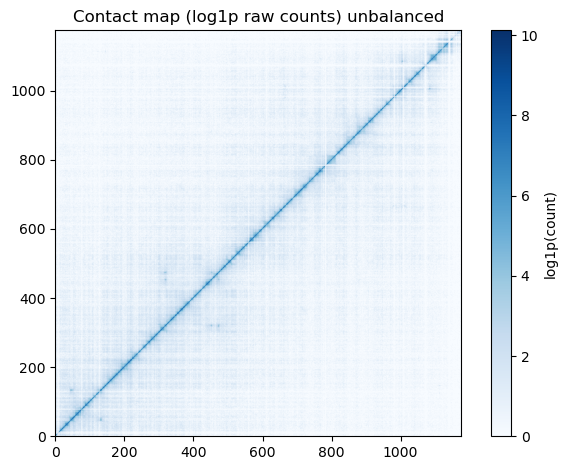

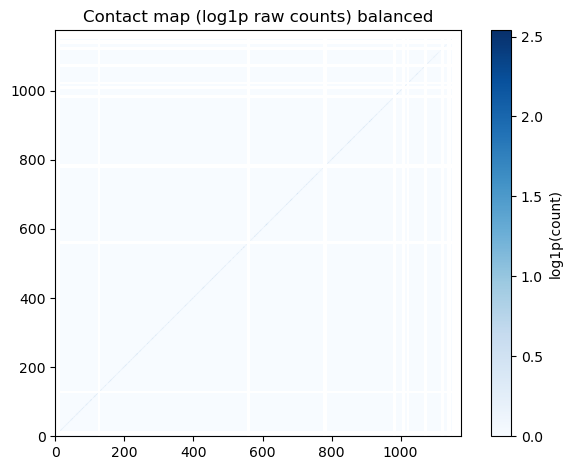

In [15]:
clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250403_PnMs_merged_balanced.20kb.cool")


mat = clr.matrix(balance=False).fetch("2L_JJg14_057")

print("Matrix stats:")
print(f"Max value: {np.max(mat)}")
print(f"Min value: {np.min(mat)}")
print(f"NaNs present: {np.isnan(mat).any()}")
print(f"Rows with all zeros: {np.sum(np.all(mat == 0, axis=1))}")
print(f"Columns with all zeros: {np.sum(np.all(mat == 0, axis=0))}")

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("Contact map (log1p raw counts) unbalanced")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()

mat = clr.matrix(balance=True).fetch("2L_JJg14_057")
mat = np.clip(mat, 0, np.percentile(mat, 99))  # Cap values at the 99th percentile

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("Contact map (log1p raw counts) balanced")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()



Balancing at 40k resolution

In [3]:
cool_path = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250403_PnMs_merged_diploidGenome.40kb.cool"
balanced_cool_path = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250403_PnMs_merged_balanced.40kb.cool"

chromsizes_path = "/data/alhajabed/FlyHiC/PoreC/diploid_genome.chromsizes"
chromsizes = pd.read_csv(chromsizes_path, sep="\t", header=None, names=["chrom", "size"])

clr = cooler.Cooler(cool_path)

mat = clr.matrix(balance=False).fetch("2L_JJg14_057")
print("NaNs present:", np.isnan(mat).any())
print("Zeros on diagonal:", np.any(np.diag(mat) == 0))
print("Rows with all zeros:", np.sum(np.all(mat == 0, axis=1)))
print("Cols with all zeros:", np.sum(np.all(mat == 0, axis=0)))

# Run balancing
weights, stats = cooler.balance_cooler(clr, max_iters=1000, tol=1e-5)

print("Balancing stats:", stats)
print("Weights head:", weights[:10])

# Attach weights to the bins table
bins = clr.bins()[:]
bins["weight"] = weights  



# Save the balanced cooler file
cooler.create_cooler(
    balanced_cool_path,
    bins=bins,
    pixels=clr.pixels()[:],
    metadata={"chromsizes": dict(zip(chromsizes["chrom"], chromsizes["size"]))}  # Add chromsizes to metadata
)

print(f"Balanced cooler saved to {balanced_cool_path}")

clr_cool = cooler.Cooler(balanced_cool_path)
print(clr_cool.info)

NaNs present: False
Zeros on diagonal: True
Rows with all zeros: 1
Cols with all zeros: 1


/localenv/erikson/anaconda/envs/PoreC/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/localenv/erikson/anaconda/envs/PoreC/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Balancing stats: {'tol': 1e-05, 'min_nnz': 10, 'min_count': 0, 'mad_max': 5, 'cis_only': False, 'ignore_diags': 2, 'scale': 145220.78194863952, 'converged': True, 'var': 9.792406124760614e-06, 'divisive_weights': False}
Weights head: [0.01510998 0.02115341 0.01241457 0.01765326 0.01344857 0.01019319
        nan        nan        nan        nan]
Balanced cooler saved to /data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250403_PnMs_merged_balanced.40kb.cool
{'bin-size': 20000, 'bin-type': 'fixed', 'creation-date': '2025-07-02T08:45:06.986959', 'format': 'HDF5::Cooler', 'format-url': 'https://github.com/open2c/cooler', 'format-version': 3, 'generated-by': 'cooler-0.10.2', 'genome-assembly': 'unknown', 'metadata': {'chromsizes': {'2L_JJg14_057': 23513712, '2R_JJg14_057': 25286936, '3L_JJg14_057': 28110227, '3R_JJg14_057': 32079331, '4_JJg14_057': 1348131, 'X_JJg14_057': 23542271, 'Y_JJg14_057': 3667352, 'dmel_mitochondrion_genome_JJg14_057': 19517, 'Unmapped_Scaffold_8_JJg14_057': 887

Plotting the 40kb

Matrix stats:
Max value: 24921
Min value: 0
NaNs present: False
Rows with all zeros: 1
Columns with all zeros: 1


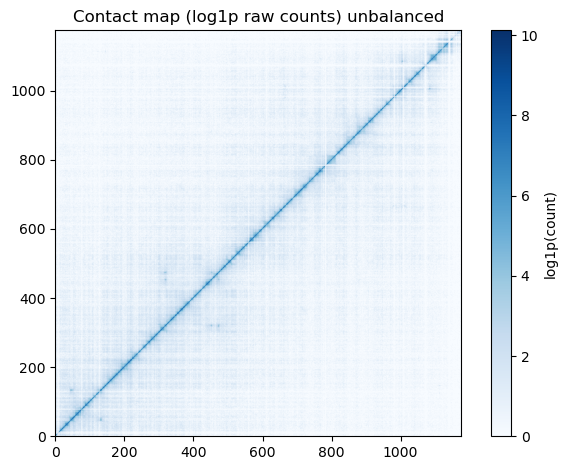

Index(['region1', 'region2', 'dist', 'dist_bp', 'contact_frequency', 'n_total',
       'n_valid', 'count.sum', 'count.avg', 'count.avg.smoothed',
       'count.avg.smoothed.agg'],
      dtype='object')
        region1       region2  dist  dist_bp  contact_frequency  n_total  \
0  2L_JJg14_057  2L_JJg14_057     0        0                NaN     1176   
1  2L_JJg14_057  2L_JJg14_057     1    20000           1.458742     1175   
2  2L_JJg14_057  2L_JJg14_057     2    40000         126.538883     1174   
3  2L_JJg14_057  2L_JJg14_057     3    60000          80.866641     1173   
4  2L_JJg14_057  2L_JJg14_057     4    80000          55.650498     1172   

   n_valid  count.sum   count.avg  count.avg.smoothed  count.avg.smoothed.agg  
0     1176        NaN         NaN                 NaN                     NaN  
1     1175        NaN         NaN            1.912187                1.458742  
2     1174   210722.0  179.490630          164.935621              126.538883  
3     1173   128268.0

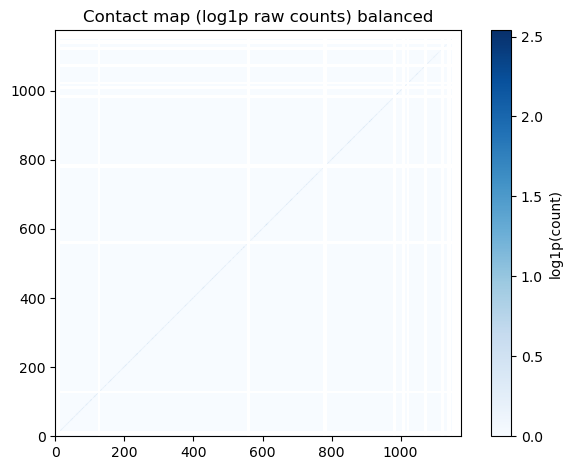

In [5]:
clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250403_PnMs_merged_balanced.40kb.cool")

mat = clr.matrix(balance=False).fetch("2L_JJg14_057")

print("Matrix stats:")
print(f"Max value: {np.max(mat)}")
print(f"Min value: {np.min(mat)}")
print(f"NaNs present: {np.isnan(mat).any()}")
print(f"Rows with all zeros: {np.sum(np.all(mat == 0, axis=1))}")
print(f"Columns with all zeros: {np.sum(np.all(mat == 0, axis=0))}")

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("Contact map (log1p raw counts) unbalanced")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()

expected = expected_cis(clr, clr_weight_name=None)
print(expected.columns)
print(expected.head())

mat = clr.matrix(balance=True).fetch("2L_JJg14_057")

print("Matrix stats:")
print(f"Max value: {np.max(mat)}")
print(f"Min value: {np.min(mat)}")
print(f"NaNs present: {np.isnan(mat).any()}")
print(f"Rows with all zeros: {np.sum(np.all(mat == 0, axis=1))}")
print(f"Columns with all zeros: {np.sum(np.all(mat == 0, axis=0))}")

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("Contact map (log1p raw counts) balanced")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()

Balancing works but the matrix looks strange, removing the extra chromosome and rebalancing after blacklisting the abnormally low and abnormally high regions, maybe the repetitive sequences is throwing the balancing off 

In [13]:
clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250403_PnMs_merged_diploidGenome.20kb.cool")
bins = clr.bins()[:]
bin_size = clr.info['bin-size']  


# Compute per-bin coverage (sum of contacts for each bin)
matrix = clr.matrix(balance=False)[:]
coverage = matrix.sum(axis=0)  # Sum contacts for each bin


# Define thresholds
low_thresh = np.percentile(coverage[coverage > 0], 2)  # 2nd percentile (excluding 0s)
high_thresh = np.percentile(coverage, 99)              # 99th percentile (extreme high)

# Mask bins
low_coverage_mask = (coverage <= low_thresh) | (coverage == 0)
high_coverage_mask = (coverage >= high_thresh)

# Combine masks
blacklist_mask = low_coverage_mask | high_coverage_mask
blacklisted_bins = bins[blacklist_mask]

# Export to BED
bed = blacklisted_bins[['chrom', 'start', 'end']]
bed.to_csv("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/drosophila_blacklist.bed", sep='\t', header=False, index=False)

# Optional: Print stats
print(f"Total bins: {len(bins)}")
print(f"Low coverage bins: {np.sum(low_coverage_mask)}")
print(f"High coverage bins: {np.sum(high_coverage_mask)}")
print(f"Total blacklisted bins: {len(bed)}")

Total bins: 17634
Low coverage bins: 1206
High coverage bins: 177
Total blacklisted bins: 1383



(PoreC) erikson@deep22:/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools$ cooler balance 20250403_PnMs_merged_diploidGenome.20kb.cool --blacklist drosophila_blacklist.bed --mad-max 5 --min-nnz 10 --max-iters 10000 --tol 1e-4
INFO:cooler.balance:variance is 0.00010877307482715734
INFO:cooler.balance:variance is 0.00010050269678965142
INFO:cooler.balance:variance is 9.28588661426533e-05

Plotting the new balanced cooler

Matrix stats:
Max value (excluding NaNs): 11.66465501927432
Min value (excluding NaNs): 0.0
NaNs present: True
Rows with all NaNs: 48
Columns with all NaNs: 48
Total rows: 1176
Total columns: 1176


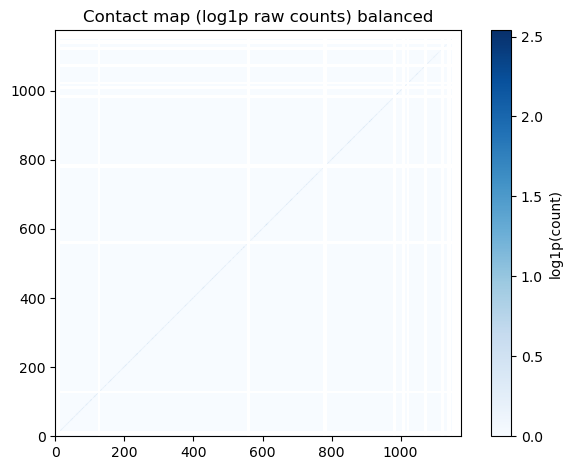

In [19]:
clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250403_PnMs_merged_balanced.20kb.cool")

mat = clr.matrix(balance=True).fetch("2L_JJg14_057")
print("Matrix stats:")
print(f"Max value (excluding NaNs): {np.nanmax(mat)}")
print(f"Min value (excluding NaNs): {np.nanmin(mat)}")
print(f"NaNs present: {np.isnan(mat).any()}")
print(f"Rows with all NaNs: {np.sum(np.all(np.isnan(mat), axis=1))}")
print(f"Columns with all NaNs: {np.sum(np.all(np.isnan(mat), axis=0))}")
print(f"Total rows: {mat.shape[0]}")
print(f"Total columns: {mat.shape[1]}")

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("Contact map (log1p raw counts) balanced")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()

Plotting the balanced matrix

INFO:root:creating a Pool of 2 workers
/tmp/ipykernel_52834/3854941717.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cvd_smooth_agg['balanced.avg.smoothed'].loc[cvd_smooth_agg['dist'] < 2] = np.nan


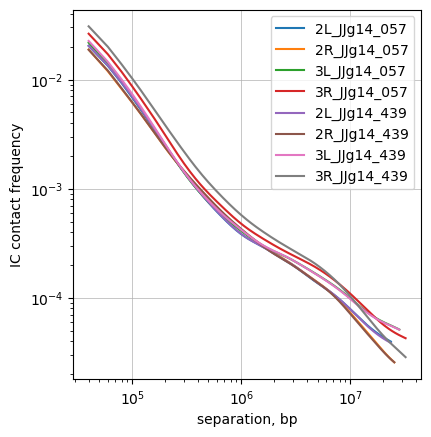

In [30]:
chroms = ["2L_JJg14_057", "2L_JJg14_439", "2R_JJg14_057", "2R_JJg14_439"]  
chromsizes_path = "/data/alhajabed/FlyHiC/PoreC/diploid_genome.chromsizes.v2"
chromsizes = pd.read_csv(chromsizes_path, sep="\t", header=None, names=["chrom", "size"])

clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250403_PnMs_merged_diploidGenome.20kb.cool")

# compute P(s) curves
cvd_smooth_agg = cooltools.expected_cis(
    clr=clr,
    view_df=None,
    smooth=True,
    aggregate_smoothed=True,
    smooth_sigma=0.1,
    nproc=2
    )

# filter short distances
cvd_smooth_agg['balanced.avg.smoothed'].loc[cvd_smooth_agg['dist'] < 2] = np.nan

# plot
fig, ax = plt.subplots(1,1)

for region in chromsizes['chrom']:
    ax.loglog(
        cvd_smooth_agg['dist_bp'].loc[cvd_smooth_agg['region1']==region],
        cvd_smooth_agg['balanced.avg.smoothed'].loc[cvd_smooth_agg['region1']==region],
    )
    ax.set(
        xlabel='separation, bp',
        ylabel='IC contact frequency')
    ax.set_aspect(1.0)
    ax.grid(lw=0.5)

ax.legend(chromsizes['chrom'], loc='upper right')

Filter pairs and keep the assembled chromosomes and modify the chromosome names to distinguish between cis and trans contacts

In [ ]:

def filter_pairs_by_specific_chromosomes(input_file, output_file):
    # List of chromosomes to filter
    target_chromosomes = ["2L_JJg14_439","2R_JJg14_439", "3L_JJg14_439", "3R_JJg14_439", "4_JJg14_439", "X_JJg14_439", "Y_JJg14_439", "2L_JJg14_057", "2R_JJg14_057", "3L_JJg14_057", "3R_JJg14_057", "4_JJg14_057", "X_JJg14_057", "Y_JJg14_057"]
    buffer = []
    
    buffer_size = 10000

    with gzip.open(input_file, 'rt') as infile, gzip.open(output_file, 'wt') as outfile:
        for line in infile:
            if line.startswith("#"):  # Process header lines
                # Check if the header line starts with any of the target chromosomes
                if line.startswith("#chromsize"):
                    parts = line.strip().split(" ")
                    if parts[1] in target_chromosomes:
                        #create a new chromosome trans and add it to the header
                        line = line.replace("_JJg14_057", "_trans")
                        line = line.replace("_JJg14_439", "_trans")
                        buffer.append(line)
                        #and then replace trans with nothing and add the sis chromosomes to header
                        line = line.replace("_trans", "")
                        buffer.append(line)
                elif line.startswith("#samheader: @SQ"):
                    parts = line.strip().split(":")
                    parts2 = parts[2].strip().split("LN")
                    if parts2[0].strip() in target_chromosomes:
                        line = line.replace("_JJg14_057", "_trans")
                        line = line.replace("_JJg14_439", "_trans")
                        buffer.append(line)
                        line = line.replace("_trans", "")
                        buffer.append(line)
                else:
                    buffer.append(line)

                outfile.writelines(buffer)
                buffer=[]
                continue
            parts = line.strip().split("\t")
            # Check if both parts[1] and parts[3] are in the target chromosomes list
            if parts[1] in target_chromosomes and parts[3] in target_chromosomes:
                
                if parts[1] == parts[3]:
                    line = line.replace("_JJg14_057", "")
                    line = line.replace("_JJg14_439", "")
                else:
                    line = line.replace("_JJg14_057", "_trans")
                    line = line.replace("_JJg14_439", "_trans")
                
                buffer.append(line)
      
                if len(buffer) >= buffer_size:
                    outfile.writelines(buffer)
                    buffer=[]

        
        
input_file1 = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/24L004895_PnM1.pairs.gz"
input_file2 = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/24L004896_PnM2.pairs.gz"
input_file3 = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/24L004897_PnM3.pairs.gz"
output_file1 = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/24L004895_PnM1.filt.pairs.gz"
output_file2 = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/24L004896_PnM2.filt.pairs.gz"
output_file3 = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/24L004897_PnM3.filt.pairs.gz"
  
filter_pairs_by_specific_chromosomes(input_file1, output_file1)
filter_pairs_by_specific_chromosomes(input_file2, output_file2)
filter_pairs_by_specific_chromosomes(input_file3, output_file3)


From pairs to merged cool

(PoreC) erikson@deep22:/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools$ 

cooler cload pairs -c1 2 -p1 3 -c2 4 -p2 5 /data/processing4/erikson_pipegrp/Jumana_nextflow/dm6_genome.reduced.chromsizes:20000 24L004895_PnM1.filt.pairs.gz 24L004895_PnM1.filt.pairs.cool

cooler cload pairs -c1 2 -p1 3 -c2 4 -p2 5 /data/processing4/erikson_pipegrp/Jumana_nextflow/dm6_genome.reduced.chromsizes:20000 24L004896_PnM2.filt.pairs.gz 24L004896_PnM2.filt.pairs.cool

cooler cload pairs -c1 2 -p1 3 -c2 4 -p2 5 /data/processing4/erikson_pipegrp/Jumana_nextflow/dm6_genome.reduced.chromsizes:20000 24L004897_PnM3.filt.pairs.gz 24L004897_PnM3.filt.pairs.cool

cooler merge 20250611_PnMs_merged.cool 24L004895_PnM1.filt.pairs.cool 24L004896_PnM2.filt.pairs.cool 24L004897_PnM3.filt.pairs.cool 




Some QC

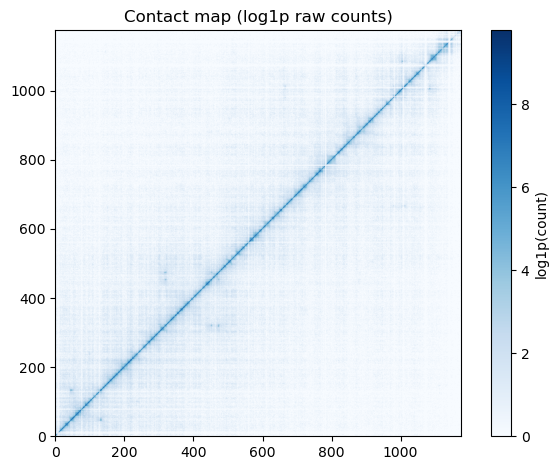

In [ ]:
clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/24L004895_PnM1.filt.pairs.cool")

# Example: plot chromosome 2L (you can adjust)
mat = clr.matrix(balance=False).fetch("2L")

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("Contact map (log1p raw counts)")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()

Contact distance decay

Index(['region1', 'region2', 'dist', 'dist_bp', 'contact_frequency', 'n_total',
       'n_valid', 'count.sum', 'count.avg', 'count.avg.smoothed',
       'count.avg.smoothed.agg'],
      dtype='object')
  region1 region2  dist  dist_bp  contact_frequency  n_total  n_valid  \
0      2L      2L     0        0                NaN     1176     1176   
1      2L      2L     1    20000           0.943372     1175     1175   
2      2L      2L     2    40000          81.167390     1174     1174   
3      2L      2L     3    60000          51.231892     1173     1173   
4      2L      2L     4    80000          34.990838     1172     1172   

   count.sum   count.avg  count.avg.smoothed  count.avg.smoothed.agg  
0        NaN         NaN                 NaN                     NaN  
1        NaN         NaN            1.599506                0.943372  
2   176267.0  150.142249          137.623994               81.167390  
3   105141.0   89.634271           86.867660               51.231892  
4   

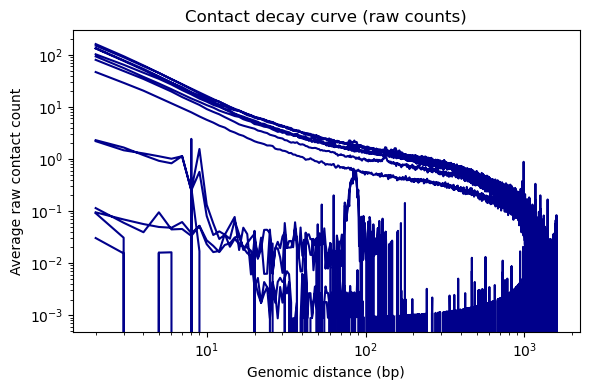

In [ ]:
# Load your .cool file
clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/24L004895_PnM1.filt.pairs.cool")

# Compute expected contact frequency from raw counts
expected = expected_cis(clr, clr_weight_name=None)
print(expected.columns)
print(expected.head())

# Plot distance decay
plt.figure(figsize=(6, 4))
plt.plot(expected['dist'], expected['count.avg'], color='darkblue')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Genomic distance (bp)")
plt.ylabel("Average raw contact count")
plt.title("Contact decay curve (raw counts)")
plt.tight_layout()
plt.show()

Taking a look at the merged cooler

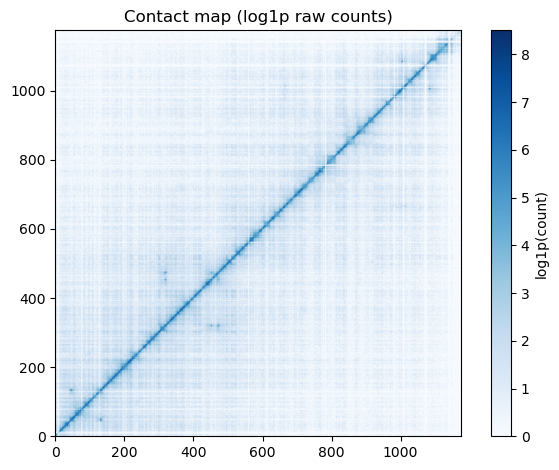

In [ ]:
import cooler
import matplotlib.pyplot as plt
import numpy as np

clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250611_PnMs_merged.cool")

mat = clr.matrix(balance=False).fetch("2L_trans")

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("Contact map (log1p raw counts)")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()

mat = clr.matrix(balance=False).fetch("2L")

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("Contact map (log1p raw counts)")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()

Dropping all of the NaNs from the matrix

In [4]:
# Load cooler file
clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250611_PnMs_merged.cool")

# Compute expected contact frequency from raw counts
expected = expected_cis(clr, clr_weight_name=None)

# Drop rows with any NaN values
expected_filtered = expected.dropna()

# Optional: reset index if needed
expected_filtered.reset_index(drop=True, inplace=True)

# Print the result
print(expected_filtered.head())

  region1 region2  dist  dist_bp  contact_frequency  n_total  n_valid  \
0      2L      2L     2    40000         194.958295     1174     1174   
1      2L      2L     3    60000         125.770503     1173     1173   
2      2L      2L     4    80000          87.261844     1172     1172   
3      2L      2L     5   100000          64.644148     1171     1171   
4      2L      2L     6   120000          50.110954     1170     1170   

   count.sum   count.avg  count.avg.smoothed  count.avg.smoothed.agg  
0   421015.0  358.615843          329.689738              194.958295  
1   257306.0  219.357204          212.799873              125.770503  
2   179033.0  152.758532          147.835846               87.261844  
3   132535.0  113.181042          109.308230               64.644148  
4   101072.0   86.386325           84.314156               50.110954  


Does the matrxi still look ok

In [10]:
import cooler
import pandas as pd

# Load the cooler file
cool_path = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250611_PnMs_merged.cool"
clr = cooler.Cooler(cool_path)

chromsizes_path = "/data/alhajabed/FlyHiC/PoreC/dm6_genome.reduced.chromsizes"
chromsizes = pd.read_csv(chromsizes_path, sep="\t", header=None, names=["chrom", "size"])

print(chromsizes.head())

# Drop rows with NaN values from the bins table
bins = clr.bins()[:]
filtered_bins = bins.dropna()

# Get the indices of the filtered bins
filtered_bin_indices = filtered_bins.index

# Filter the pixel table to exclude interactions involving removed bins
pixels = clr.pixels()[:]
filtered_pixels = pixels[
    pixels["bin1_id"].isin(filtered_bin_indices) & pixels["bin2_id"].isin(filtered_bin_indices)
]

# Save the filtered data back to a new cooler file
output_path = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250611_PnMs_filtered.cool"
cooler.create_cooler(
    output_path,
    bins=filtered_bins,
    pixels=filtered_pixels,
    metadata={"chromsizes": dict(zip(chromsizes["chrom"], chromsizes["size"]))}  # Add chromsizes to metadata
)

print(f"Filtered cooler saved to {output_path}")

      chrom      size
0        2L  23513712
1  2L_trans  23513712
2        2R  25286936
3  2R_trans  25286936
4        3L  28110227
Filtered cooler saved to /data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250611_PnMs_filtered.cool


See how the filtered cooler looks like

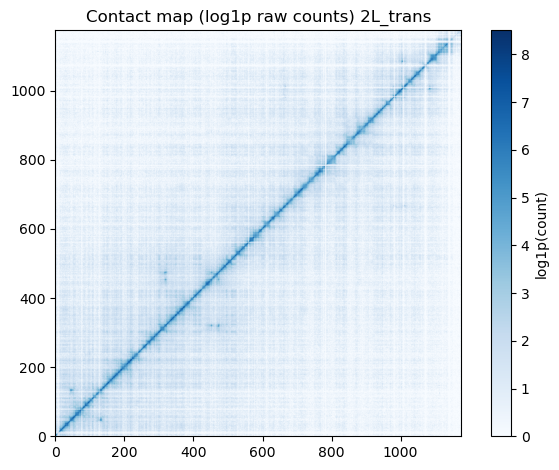

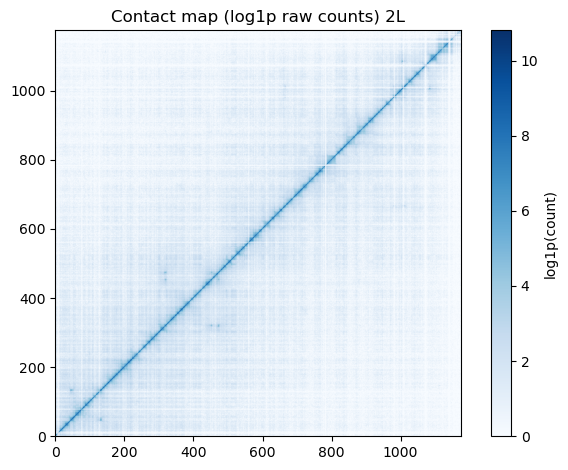

ValueError: No column 'bins/weight'found. Use ``cooler.balance_cooler`` to calculate balancing weights or set balance=False.

In [ ]:
clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250611_PnMs_filtered.cool")

mat = clr.matrix(balance=False).fetch("2L_trans")

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("Contact map (log1p raw counts) 2L_trans")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()

mat = clr.matrix(balance=False).fetch("2L")

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("Contact map (log1p raw counts) 2L")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()


Balancing the cooler

In [ ]:
cool_path = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250611_PnMs_filtered.cool"
clr = cooler.Cooler(cool_path)

# Run balancing
weights, stats = cooler.balance_cooler(clr, max_iters=1000, tol=1e-5)

# Attach weights to the bins table
clr.bins()[:]["weight"] = weights  # this only updates in memory


/localenv/erikson/anaconda/envs/PoreC/lib/python3.8/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/localenv/erikson/anaconda/envs/PoreC/lib/python3.8/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/localenv/erikson/anaconda/envs/PoreC/lib/python3.8/site-packages/cooler/balance.py:113: ConvergenceWarning: Iteration limit reached without convergence.
  warnings.warn(


Identifying why we can't balance the matrix

In [20]:
clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250611_PnMs_filtered.cool")

mat = clr.matrix(balance=False).fetch("2L_trans")
print("Matrix stats:")
print(f"Max value: {np.max(mat)}")
print(f"Min value: {np.min(mat)}")
print(f"NaNs present: {np.isnan(mat).any()}")

#Apply a cap to limit extreme values
mat = clr.matrix(balance=False).fetch("2L")
mat = np.clip(mat, 0, np.percentile(mat, 99))  # Cap values at the 99th percentile

weights, stats = cooler.balance_cooler(clr, max_iters=5000, tol=1e-5)

Matrix stats:
Max value: 4935
Min value: 0
NaNs present: False


/localenv/erikson/anaconda/envs/PoreC/lib/python3.8/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/localenv/erikson/anaconda/envs/PoreC/lib/python3.8/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/localenv/erikson/anaconda/envs/PoreC/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/localenv/erikson/anaconda/envs/PoreC/lib/python3.8/site-packages/numpy/core/_methods.py:215: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


KeyboardInterrupt: 